In [1]:
import matplotlib.pylab as plt
%matplotlib inline

from matplotlib.dates import MINUTELY, SECONDLY
from matplotlib.dates import DateFormatter
from matplotlib.dates import rrulewrapper
from matplotlib.dates import RRuleLocator

import pandas as pd
import tables as tb
import numpy  as np
from glob import glob
from datetime        import datetime

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_files(run):
    folder = f'/analysis/{run}/hdf5/data/*h5'
    files = glob(folder)
    files.sort()
    return files

In [3]:
def get_evt_times(files):
    time_dfs = []

    for i, fname in enumerate(files):
        df_time = pd.read_hdf(fname, 'dateEvents')
        df_time['fileno'] = i
        time_dfs.append(df_time)
    df_times = pd.concat(time_dfs)
    df_times['date'] = pd.to_datetime(df_times.timestamp, unit='us')

    # Compute time difference between one event and the next
    df_times['time_diff'] = np.abs((df_times.timestamp/1e6).diff(periods=-1))
    df_times = df_times.fillna(0)
    return df_times

In [4]:
def filter_df_evts(df, evt_start, evt_end):
    # Set filter
    evt_filter = (df.evt_number >= evt_start) & (df.evt_number < evt_end)
    if np.isnan(evt_end):
        evt_filter = (df.evt_number >= evt_start)
    
    df_filtered = df[evt_filter]
    return df_filtered

In [5]:
def classify_events_based_on_time(df_times, ngroups=3):
    # n_groups -> 3 if separator run is included, 2 otherwise
    time_diffs = df_times.time_diff.values
    kmeans = KMeans(n_clusters=ngroups).fit(time_diffs.reshape(-1,1))
    print(kmeans.cluster_centers_)
    df_times['label'] = kmeans.labels_
    change_run_label = np.argmax(kmeans.cluster_centers_)
    return change_run_label

In [6]:
def compute_limit_evts(df, ngroups=3):
    change_run_label = classify_events_based_on_time(df, ngroups)
    df_filtered = df[df.label == change_run_label]
    
    starts = []
    ends   = []
    files1 = []
    files2 = []

    first_evt = 0#-1
    last_evt  = 0#-1
    file_1 = 0
    file_2 = 0

    for _, row in df_filtered.iterrows():
        first_evt = last_evt#+1
        last_evt = row.evt_number
        file_1 = file_2
        file_2 = row.fileno

        starts.append(first_evt)
        ends  .append(last_evt)
        files1.append(file_1)
        files2.append(file_2)

    starts.append(last_evt)
    ends  .append(None)
    files1.append(file_2)
    files2.append(file_2)

    result = pd.DataFrame({'start' : starts,
                           'end'   : ends,
                           'file1' : files1,
                           'file2' : files2})
    return result    

In [7]:
def process_df(df, channels, field, params):
    df_filtered = df[df.channel_id.isin(channels)][['channel_id', 'count']]
    df_maxs = df_filtered.groupby('channel_id').max()
    df_tmp  = df_maxs.reset_index()
    df_tmp[field] = df_tmp.apply(lambda row: params[row.channel_id], axis=1)
    return df_tmp

In [8]:
def compute_max_counter_value_for_each_config(run, field, channels, files, limits):
    results = []
    tofpet_evts = []
    current_file1 = -1
    df = pd.DataFrame()

    for iteration, limit in limits.iterrows():
        #print(iteration)
        file1 = int(limit.file1)
        file2 = int(limit.file2)

        if file1 != current_file1:
            df = pd.read_hdf(files[file1], 'counter')
            current_file1 = file1

        df_filtered = filter_df_evts(df, limit.start, limit.end)

        if file1 != file2:
            df2          = pd.read_hdf(files[file2], 'counter')
            df2_filtered = filter_df_evts(df2, limit.start, limit.end)
            df_filtered  = pd.concat([df_filtered, df2_filtered])

            # Update file1
            df = df2
            current_file1 = file2

        tofpet_evts.append(df_filtered.shape[0])

        # TODO: pass params as arg
        params = {ch: iteration for ch in channels}
        result = process_df(df_filtered, channels, field, params)
        results.append(result)

    return pd.concat(results), tofpet_evts

In [9]:
def plot_evts_recorded_per_configuration(tofpet_evts, limits):
    date_evts = limits.start.diff().values[1:]
    max1 = 1.5 * np.max(tofpet_evts)
    max2 = 1.5 * np.max(date_evts)
    
    fig, ax1 = plt.subplots(figsize=(15,7))

    color = 'tab:red'
    ax1.set_xlabel('Parameter')
    ax1.set_ylabel('TOFPET evts', color=color)
    ax1.plot(tofpet_evts, color=color, drawstyle='steps')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0, max1])

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('DATE evts', color=color)  # we already handled the x-label with ax1
    ax2.plot(date_evts, color=color, drawstyle='steps', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0, max2])

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [10]:
def plot_time_distribution(df_times):
    dtimes = [datetime.fromtimestamp(time) for time in (df_times.timestamp/1e6).values]
    
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(figsize=(20,7))

    plt.plot_date(dtimes, np.ones_like(dtimes), '.')
    
    formatter = DateFormatter('%H:%M:%S')
    rule = rrulewrapper(SECONDLY, interval=30)
    loc = RRuleLocator(rule)

    ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_tick_params(rotation=30)
    ax.yaxis.set_visible(False)
    ax.set_title("Events time distribution")

In [11]:
def plot_all_channels(df_counts, channels, nbits):
    fig, ax = plt.subplots(figsize=(20,9))
    for i, ch in enumerate(channels):
        values = df_counts[df_counts.channel_id == ch]['count'].values

        ax = plt.subplot(8, 2, i+1)
        plt.plot(values, drawstyle='steps', linewidth=3)
        ymax = (2**nbits)
        plt.ylim(0, 1.1*ymax)

        plt.text(5, 0.5*ymax, f"ch: {ch}", horizontalalignment='center', verticalalignment='center', rotation=0, fontsize=13)

        if i in [14, 15]:
            plt.setp(ax.get_xticklabels(), fontsize=18)
        else:
            plt.setp(ax.get_xticklabels(), visible=False)

In [12]:
def process_run(run, nbits, field, channels):
    files    = get_files(run)
    df_times = get_evt_times(files)
    limits   = compute_limit_evts(df_times, ngroups=2)
    df_counts, tofpet_evts = compute_max_counter_value_for_each_config(run, field, channels, files, limits)
    plot_time_distribution(df_times)
    plot_evts_recorded_per_configuration(tofpet_evts, limits)
    
    return df_counts

In [13]:
channels = [35,39,43,44,45,49,53,55,56,57,58,59,60,61,62,63]
field = 'vth_1'
expected_values = 63

In [14]:
run_number = 9808
nbits = 22

[[0.04192608]
 [2.9420274 ]]


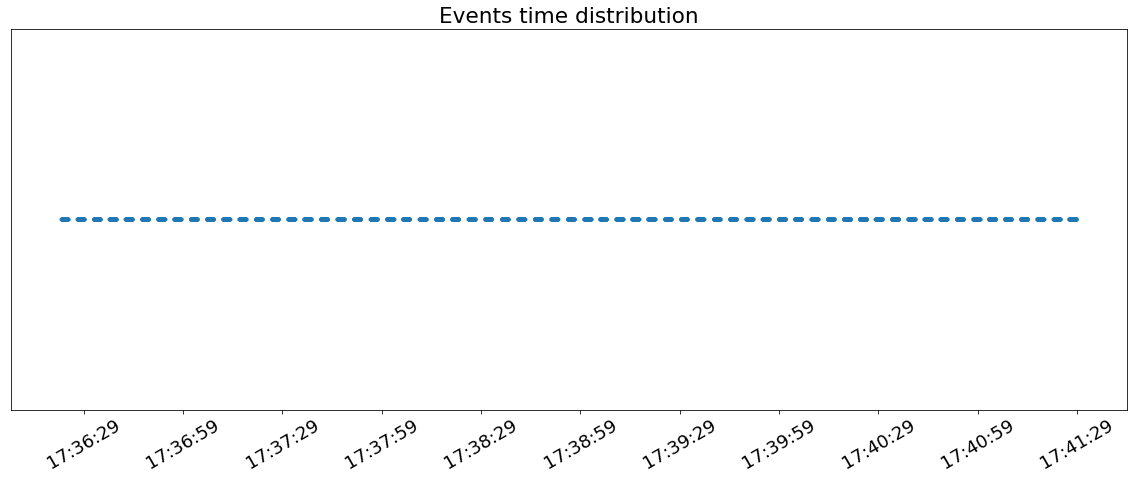

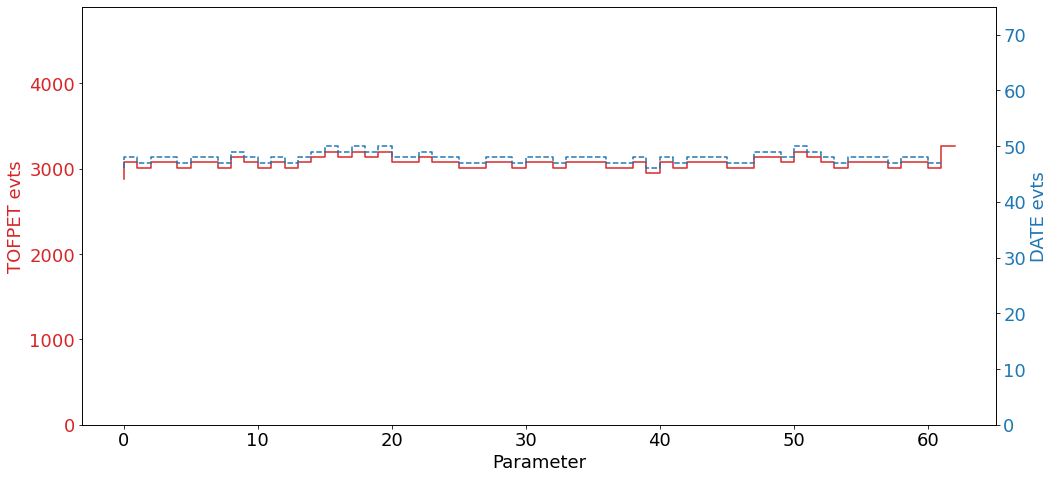

In [15]:
df_counts = process_run(run_number, nbits, field, channels)

The resulting dataframe has one row per channel and parameter value with the corresponding counter value.

In [16]:
df_counts

,channel_id,count,vth_1
0,35,0,0
1,39,0,0
2,43,0,0
3,44,0,0
4,45,0,0
...,...,...,...
11,59,4194304,62
12,60,4194304,62
13,61,4194304,62
14,62,4194304,62


The different channels can be filtered:

In [17]:
df_counts[df_counts['channel_id'] == 35]

,channel_id,count,vth_1
0,35,0,0
0,35,0,1
0,35,0,2
0,35,0,3
0,35,0,4
...,...,...,...
0,35,4194304,58
0,35,4194304,59
0,35,4194304,60
0,35,4194304,61


In [18]:
df_counts[df_counts['channel_id'] == 35]['count'].values

array([      0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       0,
            18,       0,       5,     794,   21350,  505384, 2756722,
       4121919, 4194053, 4194304, 4194304, 4194304, 4194304, 4194304,
       4194304, 4194304, 4194304, 4194304, 4194304, 4194304, 4194304,
       4194304, 4194304, 4194304, 4194304, 4194304, 4194304, 4194304,
       4194304, 4194304, 4194304, 4194304, 4194304, 4194304, 4194304],
      dtype=uint32)

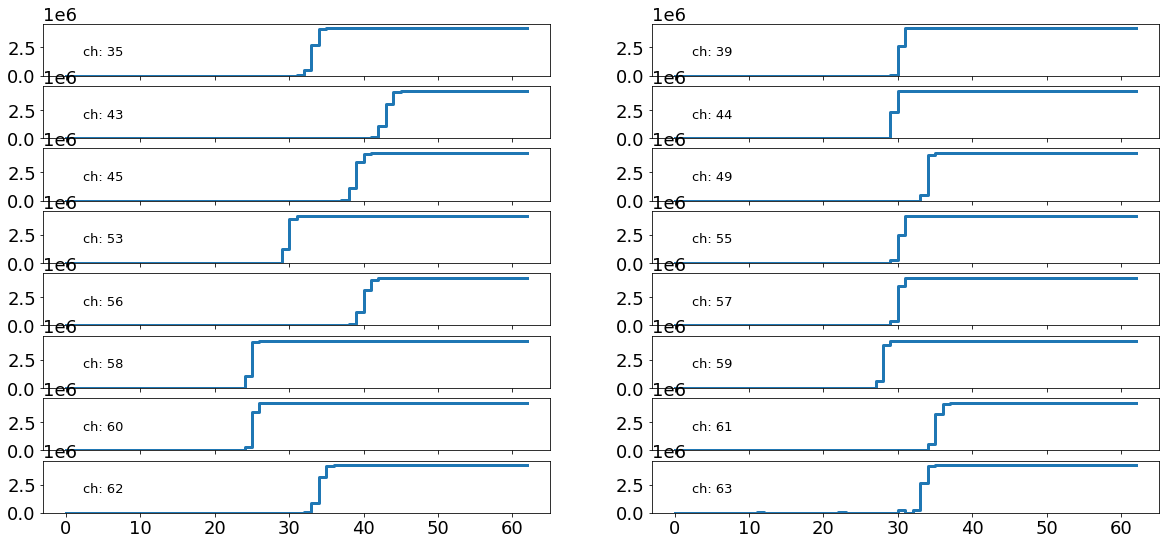

In [19]:
plot_all_channels(df_counts, channels, nbits)

# Compare several runs

In [20]:
runs = {'nbits' : 22,  'run_number' : [9808, 9809]}

In [21]:
def compare_runs(runs, field, channels):
    dfs = []
    for run in runs['run_number']:
        df = process_run(run, runs['nbits'], field, channels)
        dfs.append(df)
    return dfs

In [22]:
def plot_all_channels_multiple_runs(dfs, runs_dict, channels, title='', fname=None):
    runs = runs_dict['run_number']
    nbits = runs_dict['nbits']
    
    fig, ax = plt.subplots(figsize=(20,9))
    colors = iter(['red', 'blue', 'orange', 'green', 'brown', 'yellow'])
    
    #axes = [plt.subplot(8, 2, i+1) for i in range(16)]
    
    for df_counts, run in zip(dfs, runs):
        color = next(colors)
        for i, ch in enumerate(channels):
            values = df_counts[df_counts.channel_id == ch]['count'].values

            ax = plt.subplot(8, 2, i+1)
            #ax = axes[i]
            plt.plot(values, drawstyle='steps', linewidth=3, color=color, alpha=0.7, label=run)
            ymax = (2**nbits)
            plt.ylim(0, 1.1*ymax)

            plt.text(5, 0.5*ymax, f"ch: {ch}", horizontalalignment='center', verticalalignment='center', rotation=0, fontsize=13)
            
            ax.set_yticks([0, 2**nbits])
            max_label = '2^{{{}}}'.format(nbits)
            ax.set_yticklabels(['$0$', f'${max_label}$'])
            plt.setp(ax.get_yticklabels(), fontsize=14)
            
            if i in [14, 15]:
                plt.setp(ax.get_xticklabels(), fontsize=18)
            else:
                plt.setp(ax.get_xticklabels(), visible=False)
    
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(1.3, 7))
    plt.suptitle(title)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname)

[[0.04192608]
 [2.9420274 ]]


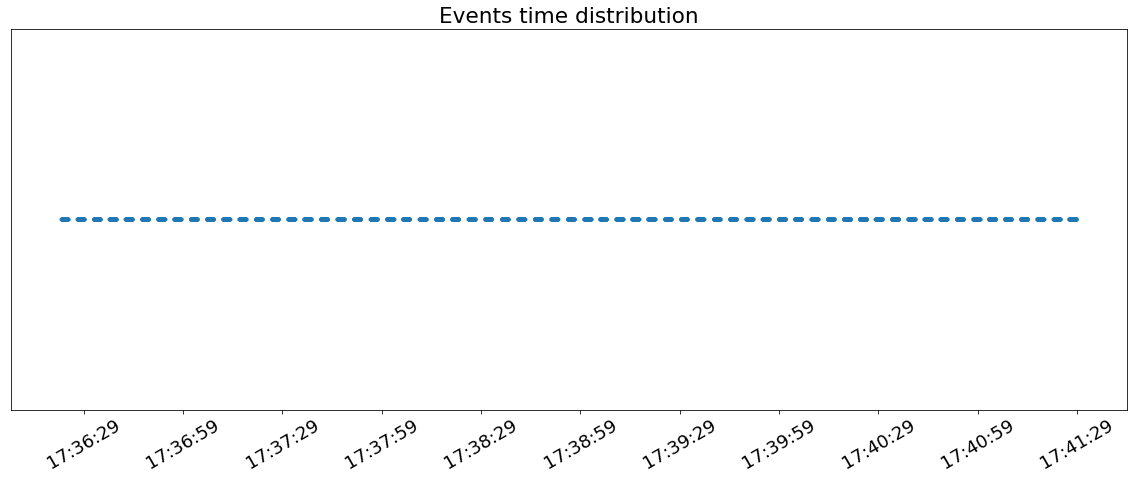

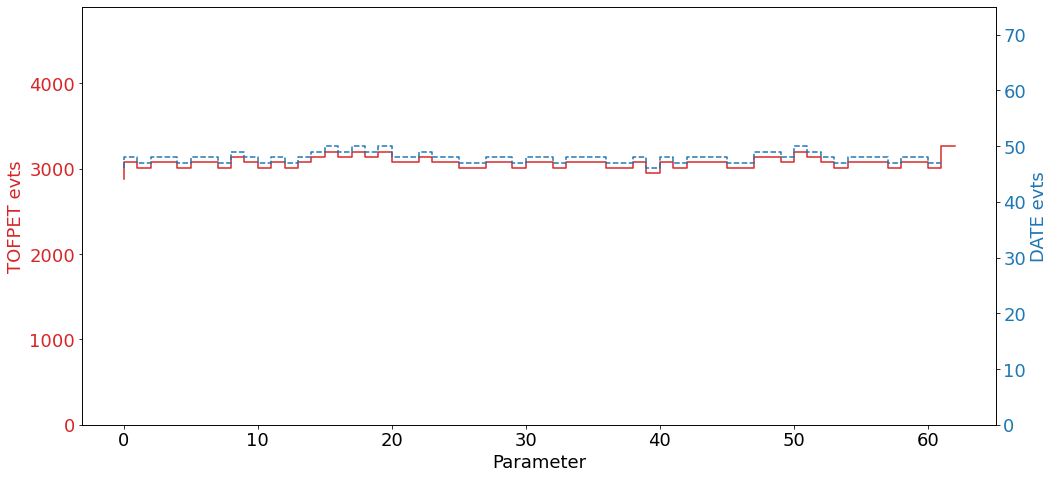

[[0.04192705]
 [2.9622    ]]


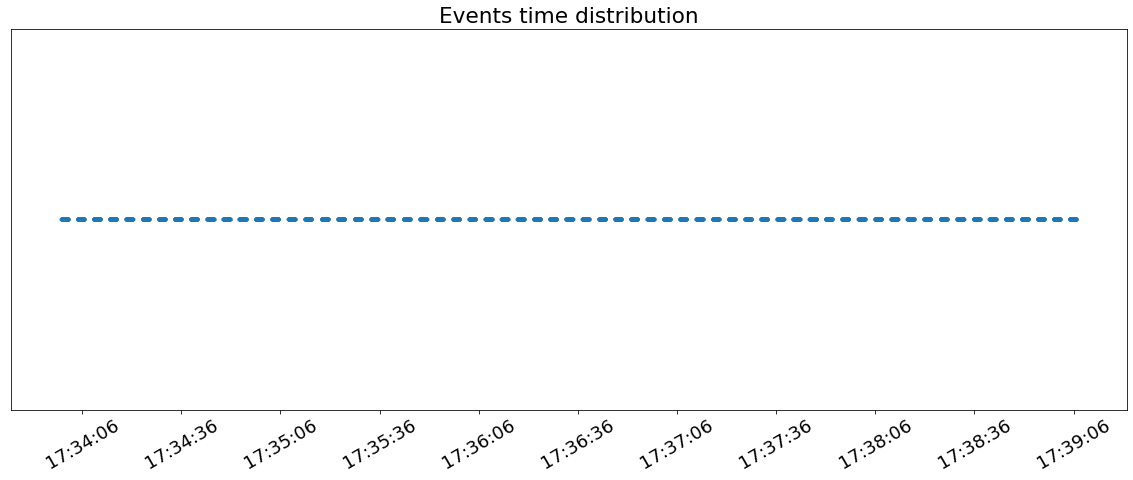

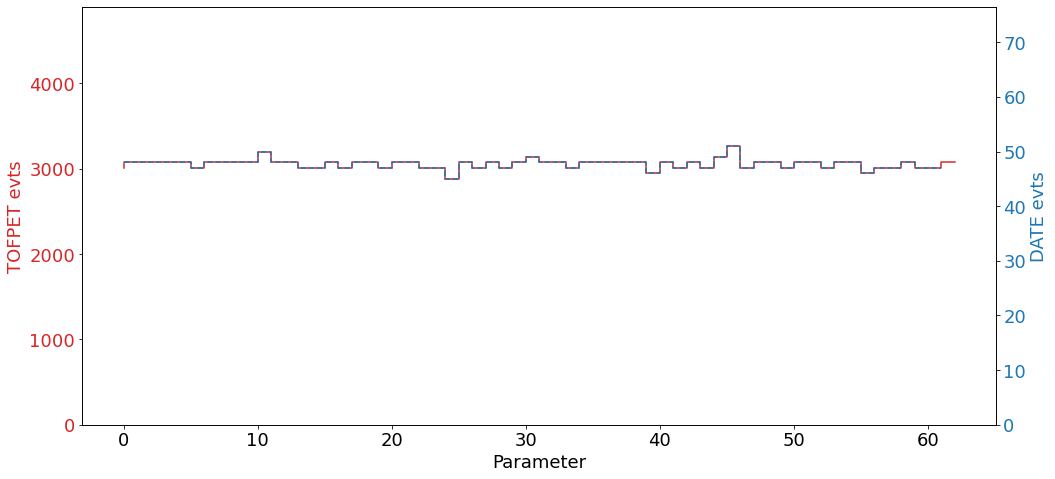

In [23]:
dfs = compare_runs(runs, field, channels)

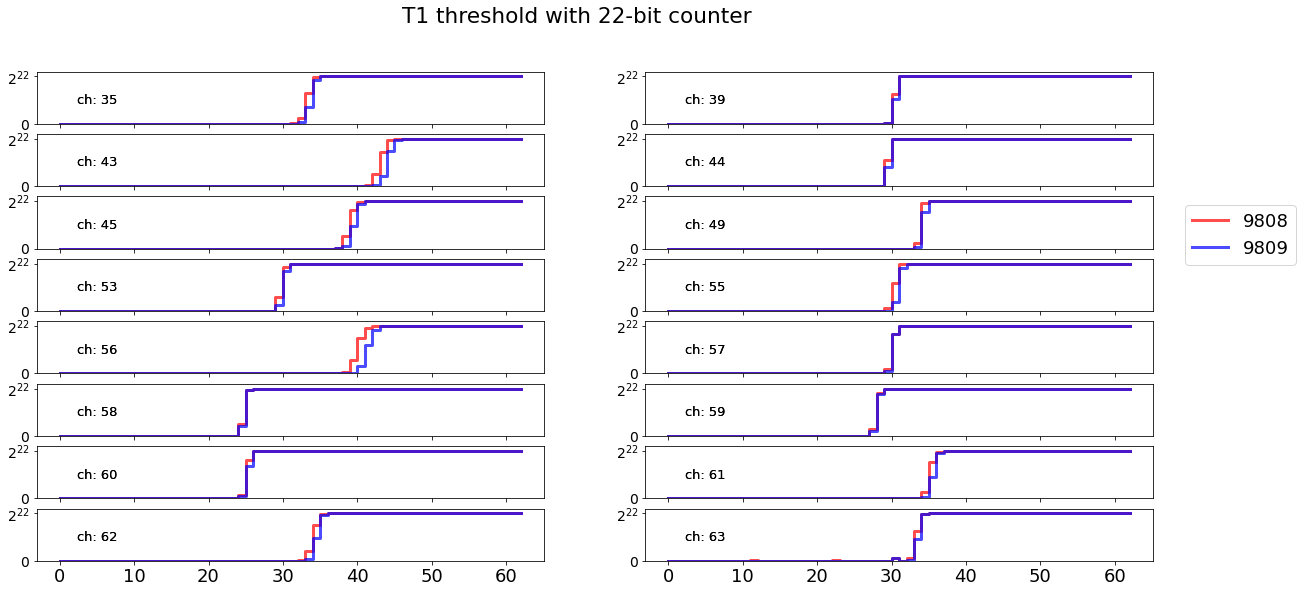

In [24]:
plot_all_channels_multiple_runs(dfs, runs, channels, title="T1 threshold with 22-bit counter")